In [ ]:
# !wget https://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip

In [1]:
!pip install torch torch-geometric

import pandas as pd
import os
from collections import defaultdict, Counter
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.nn import Linear
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.optim import Adam
from torch.nn.functional import cross_entropy
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


In [2]:
import numpy as np
def load_embeddings(file_path):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

glove_embeddings_path = 'glove.6B.50d.txt'
glove_embeddings = load_embeddings(glove_embeddings_path)

In [17]:
from google.colab import drive
drive.mount('/content/drive')
!unzip drive/MyDrive/slt_challenge/transcripts_outputFiles.zip


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  drive/MyDrive/slt_challenge/transcripts_outputFiles.zip
   creating: transcripts_outputFiles/
   creating: transcripts_outputFiles/SFT_outputFiles/
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-rec-103.txt  
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-rec-034.txt  
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-rec-131.txt  
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-rec-039.txt  
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-rec-059.txt  
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-rec-073.txt  
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-rec-030.txt  
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-rec-080.txt  
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-rec-069.txt  
  inflating: transcripts_outputFiles/S

In [18]:
import random

def set_all_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [19]:
def load_graph_info(nodes_degree_txt, nodes_edges_txt):
  nodes_features = defaultdict(dict)
  edges = []
  with open(nodes_degree_txt, 'r') as nodes_degree_file, open(nodes_edges_txt, 'r') as nodes_edges_file:
      reading_nodes, reading_edges = False, False

      for line in nodes_edges_file:
          line = line.strip()
          if (not line) or line.startswith("id*int") or line.startswith("source*int"):
              continue

          if line.startswith("*Nodes"):
              # start reading node info
              reading_nodes = True
              reading_edges = False
          elif line.startswith("*DirectedEdges"):
              # start reading edge info
              reading_nodes = False
              reading_edges = True

          elif reading_nodes:
            # parse node info
              parts = line.split(" ", 2)
              node_id = int(parts[0])
              label = parts[1].strip('"')
              nodes_features[node_id]['label'] = label


          elif reading_edges:
            # parse edge info
              parts = line.split()
              source = int(parts[0])
              target = int(parts[1])
              edges.append((source, target))

      for line in nodes_degree_file:
        line = line.strip()
        if (not line) or (not line.startswith("Node Degree")):
          parts = line.split()
          node_id = int(parts[0])
          degree = parts[1].strip('"')
          nodes_features[node_id]['degree'] = degree

      # print(len(nodes_features), len(edges))
      return nodes_features, edges


def get_word_embedding(word, embedding_dim=50):
    try:
        return torch.tensor(glove_embeddings[word], dtype=torch.float)
    except KeyError:
        # for words not in the vocabulary, use a zero vector
        # print('WARNING: word not in the vocabulary: ', word)
        return torch.zeros(embedding_dim)


def prep_data_for_gnn(nodes_features, edges):
    # mapping from node ID to index
    node_id_to_index = {node_id: i for i, node_id in enumerate(nodes_features.keys())}

    # create node features: node degrees and word embeddings)
    features = []
    for node_id in nodes_features.keys():
        node_label = nodes_features[node_id]['label']
        node_embeddings = get_word_embedding(node_label)
        # print(node_id,nodes_features[node_id]['degree'])
        # new_value = torch.tensor([15], dtype=torch.int64)
        # tensor = torch.cat((node_embeddings, new_value))

        features.append(node_embeddings)
    x = torch.stack(features)  # Node feature matrix

    # create edge index tensor
    edge_index = torch.tensor(
        [[node_id_to_index[src], node_id_to_index[dst]] for src, dst in edges],
        dtype=torch.long,
    ).t().contiguous()
    return x, edge_index


def get_datalist(id_list, label_list, transcript_folder):
  """
  returns a list of Data objects
  """
  data_list = []
  id_label_list = [(id, label) for id, label in zip(id_list, label_list)]
  for id, label in id_label_list:
    filepath = os.path.join(transcript_folder, id)
    nodes_features, edges = load_graph_info(f'{filepath}_dir_nodes_degree.txt', f'{filepath}_dir_nodes_edges.txt')
    x, edge_index = prep_data_for_gnn(nodes_features, edges)
    graph_data = Data(x=x, edge_index=edge_index, y=label)
    data_list.append(graph_data)
  return data_list


def get_dataloader(data_list, batch_size=None):
  if not batch_size:
    batch_size = len(data_list)
    print('Setting batch size to ', batch_size)
  return DataLoader(data_list, batch_size=batch_size, shuffle=False)


def calculate_class_weights(labels):
    class_weights = compute_class_weight(
        class_weight = 'balanced',
        classes = np.unique(labels),
        y = labels)

    return torch.tensor(class_weights, dtype=torch.float)

class GNNClassifier(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNClassifier, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return x


def train_gnn(train_datalist, train_batch_size=None, hidden_dim=64, lr=0.01, epoches=250, class_weights=None, num_classes = 3):
  torch.manual_seed(42)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  train_dataloader = get_dataloader(train_datalist, batch_size=train_batch_size)

  num_node_features = next(iter(train_dataloader)).x.size(1)

  model = GNNClassifier(input_dim=num_node_features, hidden_dim=hidden_dim, output_dim=num_classes).to(device)
  optimizer = Adam(model.parameters(), lr=lr)

  # Train
  if class_weights is not None:
      class_weights = class_weights.to(device)
  loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
  for epoch in range(epoches):  # train for 50 epochs
      model.train()
      total_loss = 0

      for batch in train_dataloader:
          batch = batch.to(device)
          optimizer.zero_grad()
          out = model(batch)
          loss = cross_entropy(out, batch.y)
          loss.backward()
          optimizer.step()
          total_loss += loss.item()

      if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.5f}')

  return model


def eval_gnn(model, eval_datalist, print_results=True, batch_size=None):
    model.eval()
    logits_list, pred_list, y_list = [], [], []
    eval_dataloader = get_dataloader(eval_datalist, batch_size=batch_size)
    for batch in eval_dataloader:
        logits = model(batch)
        pred = logits.argmax(dim=1)
        logits_list.append(logits)
        pred_list.append(pred)
        y_list.append(batch.y)
    # concatenate data from all batches
    logits_all = torch.cat(logits_list, dim=0)
    pred_all = torch.cat(pred_list, dim=0)
    y_all = torch.cat(y_list, dim=0)
    # get metrics
    results, disp = calc_metrics(y_all, pred_all)
    return logits_all, pred_all, results, disp


def calc_metrics(actual_labels, pred_vals, print_results=True):
  results = {}
  results['accuracy'] = accuracy_score(actual_labels, pred_vals)
  results['f1'] = f1_score(actual_labels, pred_vals, average='macro')
  results['precision'] = precision_score(actual_labels, pred_vals, average='macro')
  results['recall'] = recall_score(actual_labels, pred_vals, average='macro')

  cm = confusion_matrix(actual_labels, pred_vals)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['HC', 'MCI', 'DEM'])
  # print and plot results
  if print_results:
    for metric, value in results.items():
      print(f'{metric}: {value:.3f}')
    disp.plot()
    plt.show()
  return results, disp


class NNMetaModel(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
      super().__init__()
      self.fc1 = Linear(input_dim, hidden_dim)
      self.fc2 = Linear(hidden_dim, output_dim)

  def forward(self, x):
      x = self.fc1(x)
      x = x.relu()
      x = self.fc2(x)
      return x

def train_nn_metamodel(features, labels, class_weights=None, epochs=50, hidden_dim=32, lr=0.01, n_tasks=3):
    num_classes = len(torch.unique(labels))
    input_dim = n_tasks * num_classes  # input dimensions equals to number of tasks (CTD, SFT, PFT) * number of classes
    model = NNMetaModel(input_dim, hidden_dim=hidden_dim, output_dim=num_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    if class_weights is not None:
        class_weights = class_weights.to(features.device)  # Move class weights to the same device as the model
    loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(features)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')
    return model


Fold 0:

    train set for base model: 100 samples; label count: Counter({0: 52, 1: 38, 2: 10}),
    train set for meta model: 25 samples; label count: Counter({0: 13, 1: 10, 2: 2}),
    dev set for meta model: 32 samples; label count: Counter({0: 17, 1: 11, 2: 4})
Class weights for base model:  tensor([0.6410, 0.8772, 3.3333])
Class weights for combined model:  tensor([0.6410, 0.8681, 3.4722])
----------- Task: CTD -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.11462
Epoch 50, Loss: 0.43274
Epoch 100, Loss: 0.01841
Epoch 150, Loss: 0.00302
Epoch 200, Loss: 0.00150
Validating on meta model train set...
Setting batch size to  25
accuracy: 0.480
f1: 0.304
precision: 0.342
recall: 0.323


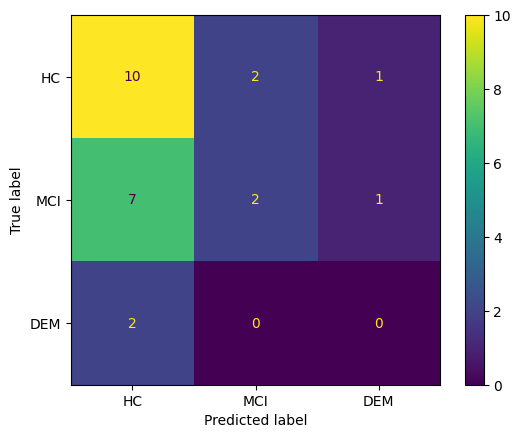

Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.406
f1: 0.283
precision: 0.271
recall: 0.298


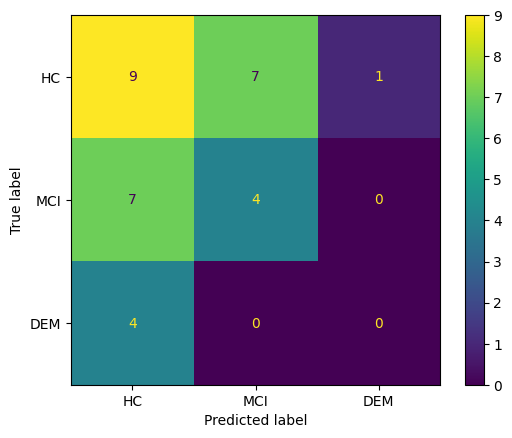

Training on base model train set + meta model train set...
Setting batch size to  125
Epoch 0, Loss: 1.11585
Epoch 50, Loss: 0.55002
Epoch 100, Loss: 0.05269
Epoch 150, Loss: 0.00514
Epoch 200, Loss: 0.00226
Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.438
f1: 0.315
precision: 0.303
recall: 0.339


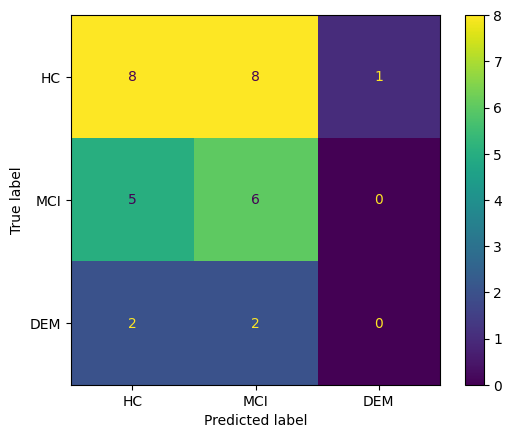

----------- Task: SFT -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.10922
Epoch 50, Loss: 0.15599
Epoch 100, Loss: 0.00344
Epoch 150, Loss: 0.00139
Epoch 200, Loss: 0.00082
Validating on meta model train set...
Setting batch size to  25
accuracy: 0.360
f1: 0.243
precision: 0.241
recall: 0.246


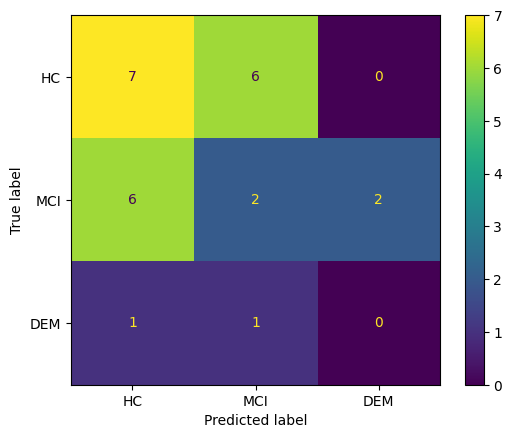

Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.625
f1: 0.523
precision: 0.574
recall: 0.509


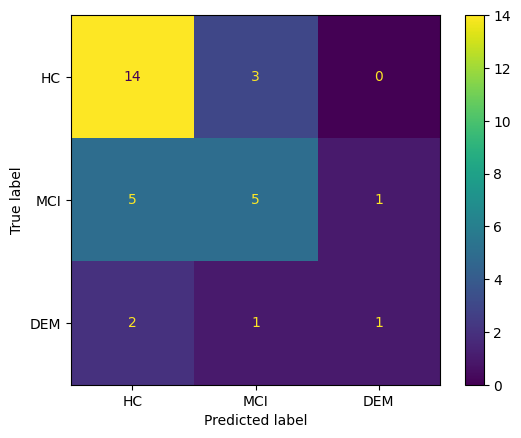

Training on base model train set + meta model train set...
Setting batch size to  125
Epoch 0, Loss: 1.11367
Epoch 50, Loss: 0.32773
Epoch 100, Loss: 0.00661
Epoch 150, Loss: 0.00189
Epoch 200, Loss: 0.00104
Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.469
f1: 0.339
precision: 0.342
recall: 0.348


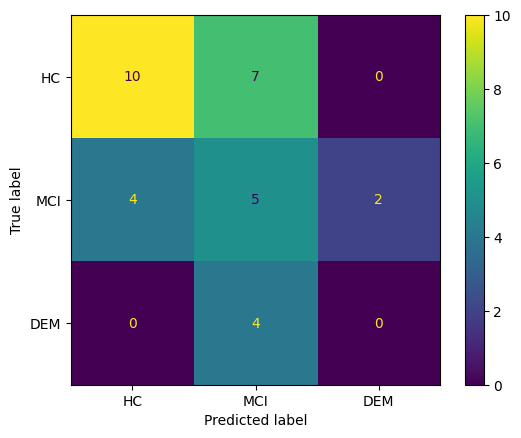

----------- Task: PFT -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.08824
Epoch 50, Loss: 0.00430
Epoch 100, Loss: 0.00028
Epoch 150, Loss: 0.00018
Epoch 200, Loss: 0.00013
Validating on meta model train set...
Setting batch size to  25
accuracy: 0.400
f1: 0.312
precision: 0.359
recall: 0.279


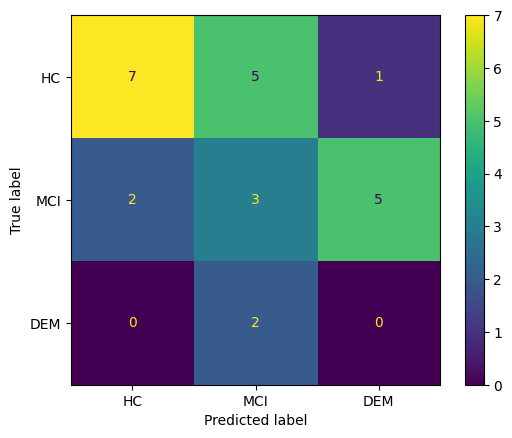

Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.469
f1: 0.394
precision: 0.404
recall: 0.390


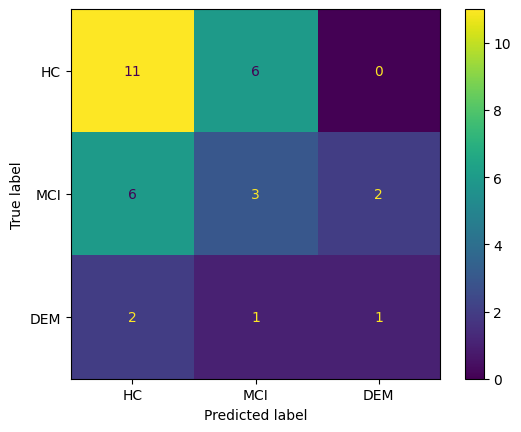

Training on base model train set + meta model train set...
Setting batch size to  125
Epoch 0, Loss: 1.08508
Epoch 50, Loss: 0.01181
Epoch 100, Loss: 0.00063
Epoch 150, Loss: 0.00036
Epoch 200, Loss: 0.00024
Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.562
f1: 0.463
precision: 0.476
recall: 0.459


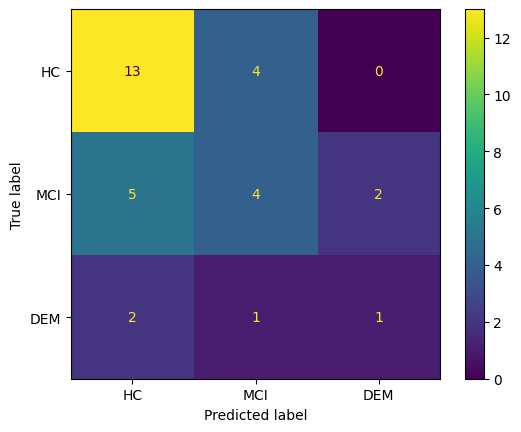

Fold 1:

    train set for base model: 100 samples; label count: Counter({0: 51, 1: 39, 2: 10}),
    train set for meta model: 25 samples; label count: Counter({0: 13, 1: 10, 2: 2}),
    dev set for meta model: 32 samples; label count: Counter({0: 18, 1: 10, 2: 4})
Class weights for base model:  tensor([0.6536, 0.8547, 3.3333])
Class weights for combined model:  tensor([0.6510, 0.8503, 3.4722])
----------- Task: CTD -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.11339
Epoch 50, Loss: 0.48962
Epoch 100, Loss: 0.05064
Epoch 150, Loss: 0.00454
Epoch 200, Loss: 0.00183
Validating on meta model train set...
Setting batch size to  25
accuracy: 0.480
f1: 0.318
precision: 0.319
recall: 0.331


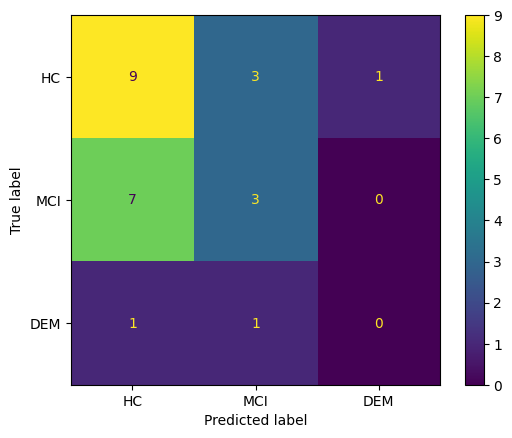

Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.531
f1: 0.377
precision: 0.367
recall: 0.389


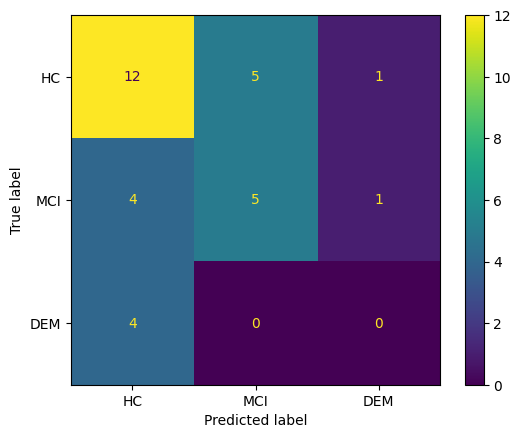

Training on base model train set + meta model train set...
Setting batch size to  125
Epoch 0, Loss: 1.11448
Epoch 50, Loss: 0.53623
Epoch 100, Loss: 0.06776
Epoch 150, Loss: 0.00563
Epoch 200, Loss: 0.00244
Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.500
f1: 0.420
precision: 0.426
recall: 0.420


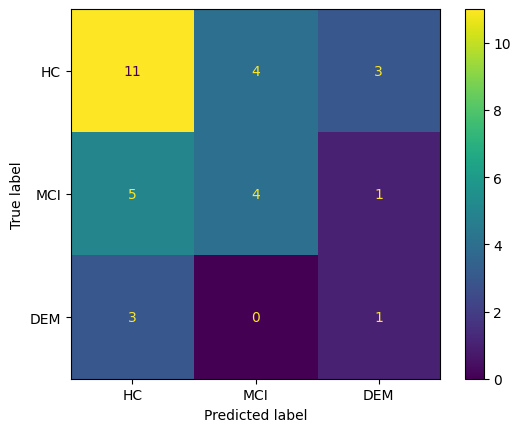

----------- Task: SFT -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.11318
Epoch 50, Loss: 0.31614
Epoch 100, Loss: 0.00469
Epoch 150, Loss: 0.00156
Epoch 200, Loss: 0.00090
Validating on meta model train set...
Setting batch size to  25
accuracy: 0.360
f1: 0.246
precision: 0.246
recall: 0.246


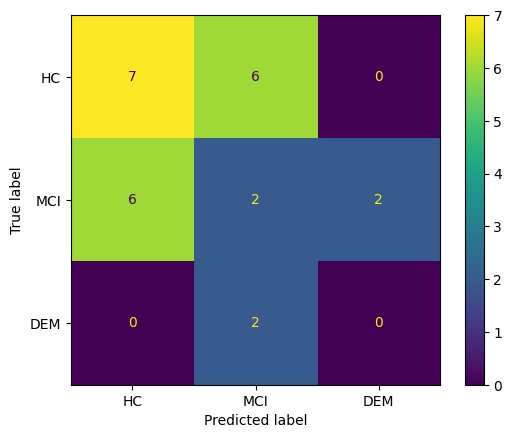

Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.594
f1: 0.404
precision: 0.385
recall: 0.426


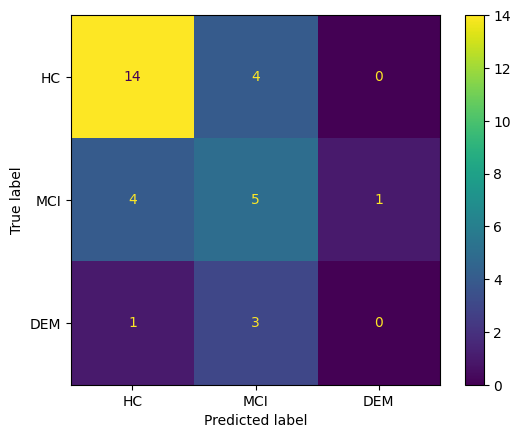

Training on base model train set + meta model train set...
Setting batch size to  125
Epoch 0, Loss: 1.11202
Epoch 50, Loss: 0.35237
Epoch 100, Loss: 0.00747
Epoch 150, Loss: 0.00196
Epoch 200, Loss: 0.00108
Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.625
f1: 0.401
precision: 0.380
recall: 0.430


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


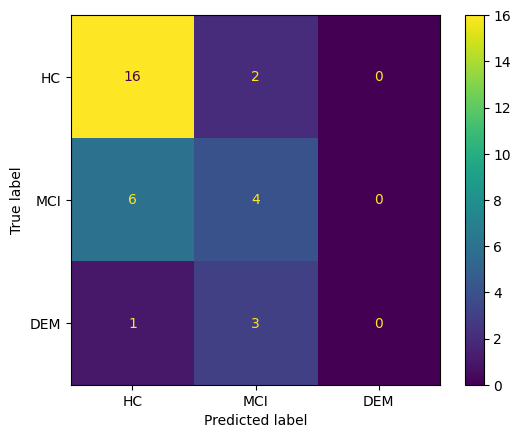

----------- Task: PFT -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.08060
Epoch 50, Loss: 0.00193
Epoch 100, Loss: 0.00027
Epoch 150, Loss: 0.00018
Epoch 200, Loss: 0.00013
Validating on meta model train set...
Setting batch size to  25
accuracy: 0.480
f1: 0.320
precision: 0.311
recall: 0.331


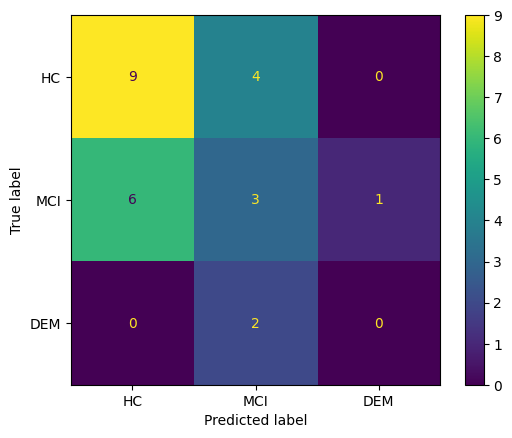

Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.469
f1: 0.356
precision: 0.378
recall: 0.337


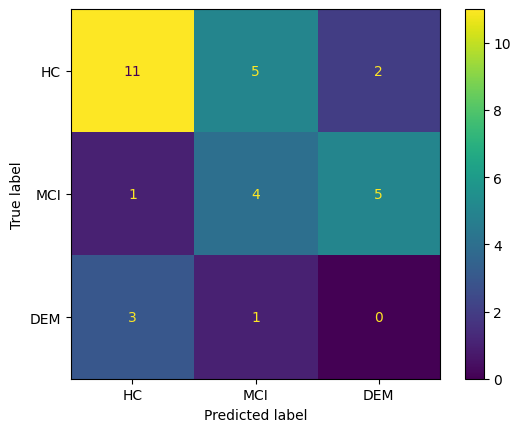

Training on base model train set + meta model train set...
Setting batch size to  125
Epoch 0, Loss: 1.08311
Epoch 50, Loss: 0.00556
Epoch 100, Loss: 0.00048
Epoch 150, Loss: 0.00030
Epoch 200, Loss: 0.00021
Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.500
f1: 0.369
precision: 0.383
recall: 0.356


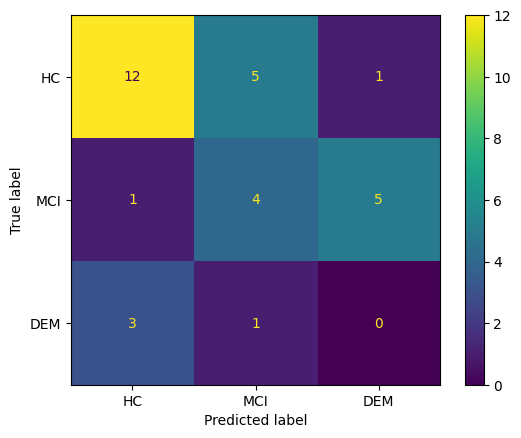

Fold 2:

    train set for base model: 100 samples; label count: Counter({0: 52, 1: 37, 2: 11}),
    train set for meta model: 26 samples; label count: Counter({0: 14, 1: 9, 2: 3}),
    dev set for meta model: 31 samples; label count: Counter({0: 16, 1: 13, 2: 2})
Class weights for base model:  tensor([0.6410, 0.9009, 3.0303])
Class weights for combined model:  tensor([0.6364, 0.9130, 3.0000])
----------- Task: CTD -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.11364
Epoch 50, Loss: 0.44590
Epoch 100, Loss: 0.02834
Epoch 150, Loss: 0.00418
Epoch 200, Loss: 0.00201
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.385
f1: 0.255
precision: 0.252
recall: 0.265


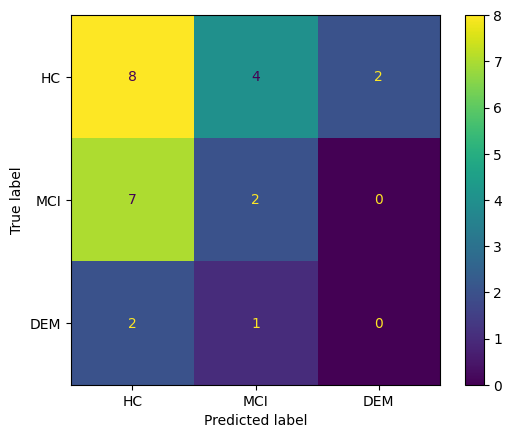

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.484
f1: 0.347
precision: 0.354
recall: 0.341


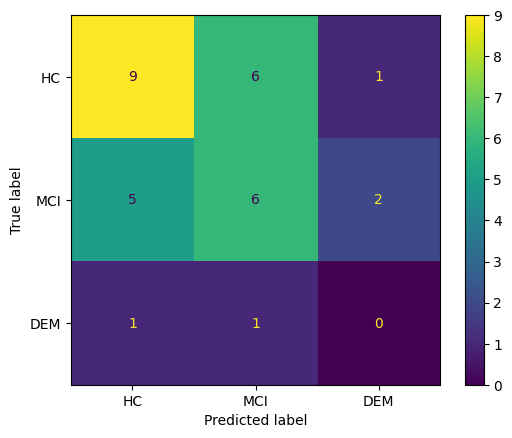

Training on base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 1.11444
Epoch 50, Loss: 0.54945
Epoch 100, Loss: 0.07410
Epoch 150, Loss: 0.00667
Epoch 200, Loss: 0.00276
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.516
f1: 0.362
precision: 0.363
recall: 0.362


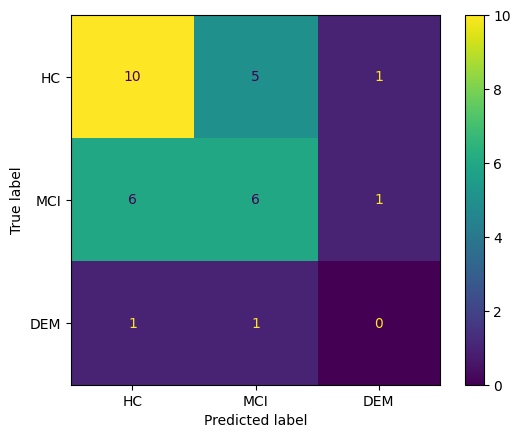

----------- Task: SFT -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.10803
Epoch 50, Loss: 0.19117
Epoch 100, Loss: 0.00264
Epoch 150, Loss: 0.00099
Epoch 200, Loss: 0.00058
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.538
f1: 0.478
precision: 0.637
recall: 0.447


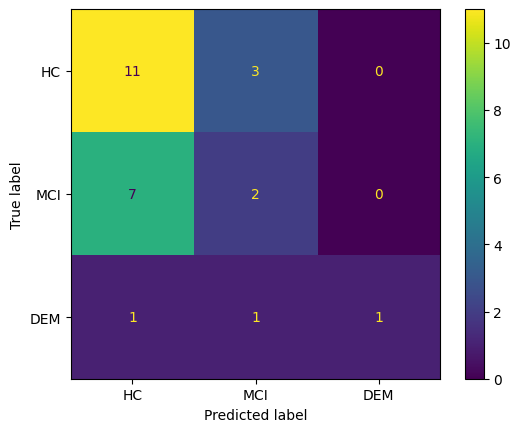

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.452
f1: 0.315
precision: 0.319
recall: 0.311


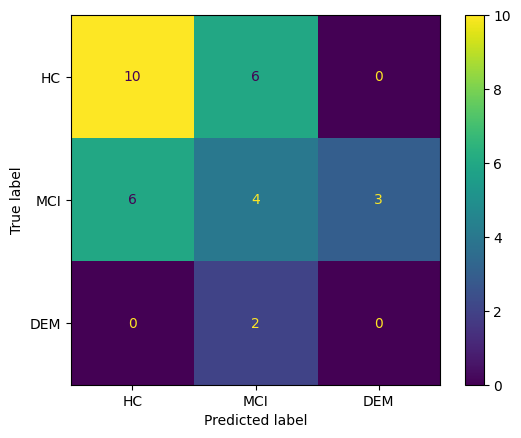

Training on base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 1.11161
Epoch 50, Loss: 0.31460
Epoch 100, Loss: 0.00561
Epoch 150, Loss: 0.00157
Epoch 200, Loss: 0.00088
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.484
f1: 0.459
precision: 0.443
recall: 0.487


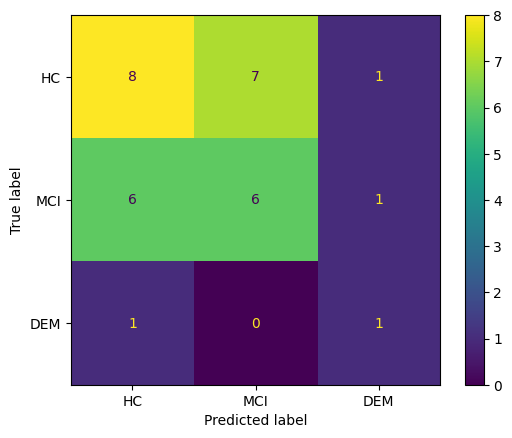

----------- Task: PFT -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.08544
Epoch 50, Loss: 0.00896
Epoch 100, Loss: 0.00050
Epoch 150, Loss: 0.00030
Epoch 200, Loss: 0.00020
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.577
f1: 0.420
precision: 0.435
recall: 0.410


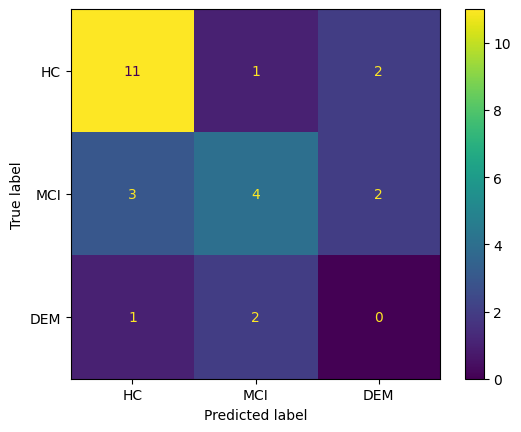

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.516
f1: 0.338
precision: 0.348
recall: 0.353


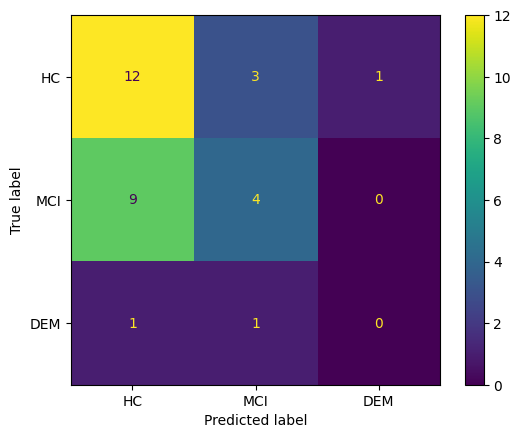

Training on base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 1.08671
Epoch 50, Loss: 0.02133
Epoch 100, Loss: 0.00080
Epoch 150, Loss: 0.00044
Epoch 200, Loss: 0.00029
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.419
f1: 0.287
precision: 0.291
recall: 0.290


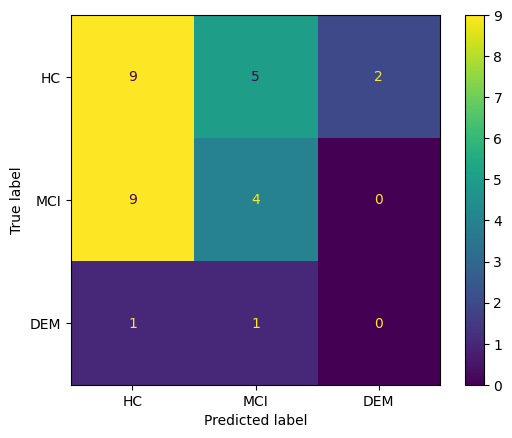

Fold 3:

    train set for base model: 100 samples; label count: Counter({0: 52, 1: 37, 2: 11}),
    train set for meta model: 26 samples; label count: Counter({0: 14, 1: 9, 2: 3}),
    dev set for meta model: 31 samples; label count: Counter({0: 16, 1: 13, 2: 2})
Class weights for base model:  tensor([0.6410, 0.9009, 3.0303])
Class weights for combined model:  tensor([0.6364, 0.9130, 3.0000])
----------- Task: CTD -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.11352
Epoch 50, Loss: 0.48044
Epoch 100, Loss: 0.03092
Epoch 150, Loss: 0.00542
Epoch 200, Loss: 0.00256
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.462
f1: 0.332
precision: 0.339
recall: 0.325


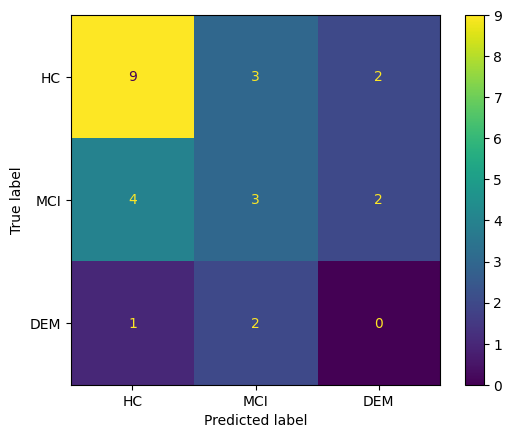

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.581
f1: 0.416
precision: 0.424
recall: 0.409


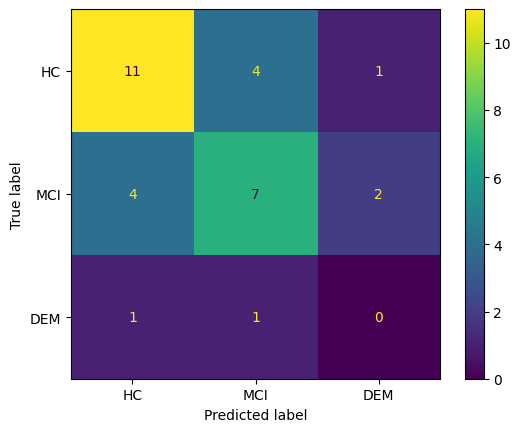

Training on base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 1.11445
Epoch 50, Loss: 0.60971
Epoch 100, Loss: 0.11360
Epoch 150, Loss: 0.00976
Epoch 200, Loss: 0.00357
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.548
f1: 0.361
precision: 0.357
recall: 0.378


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


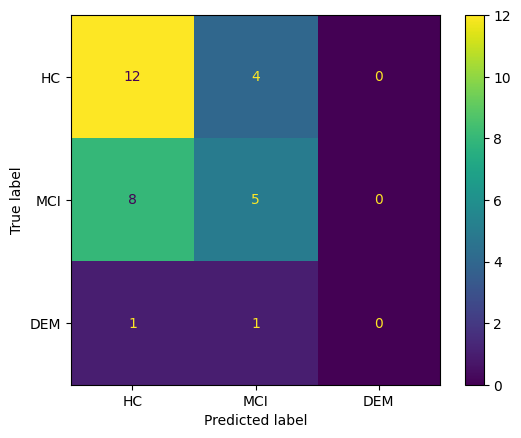

----------- Task: SFT -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.11199
Epoch 50, Loss: 0.22496
Epoch 100, Loss: 0.00243
Epoch 150, Loss: 0.00101
Epoch 200, Loss: 0.00062
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.538
f1: 0.363
precision: 0.344
recall: 0.386


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


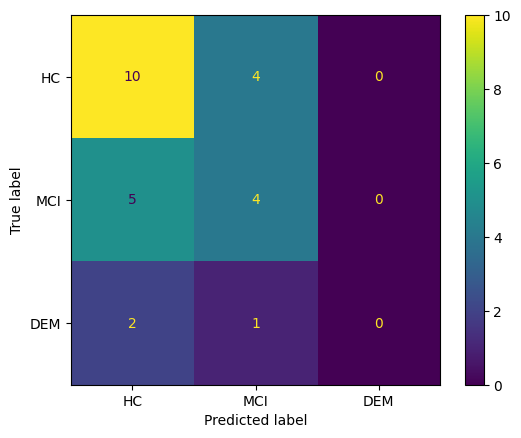

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.516
f1: 0.366
precision: 0.367
recall: 0.367


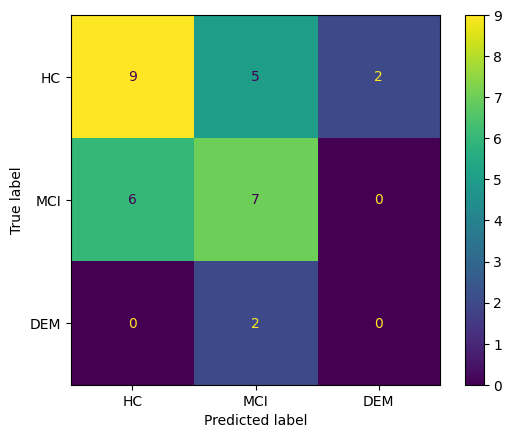

Training on base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 1.11406
Epoch 50, Loss: 0.33240
Epoch 100, Loss: 0.00564
Epoch 150, Loss: 0.00182
Epoch 200, Loss: 0.00103
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.581
f1: 0.399
precision: 0.386
recall: 0.413


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


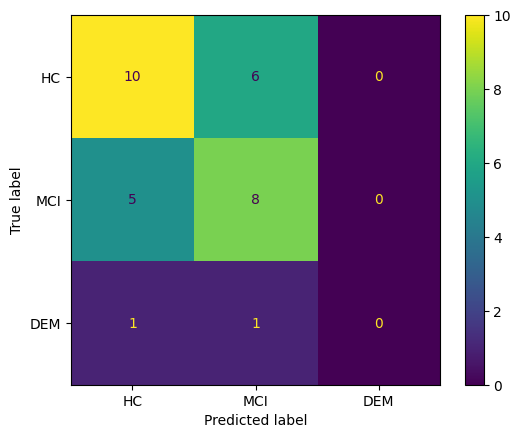

----------- Task: PFT -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.08615
Epoch 50, Loss: 0.00489
Epoch 100, Loss: 0.00031
Epoch 150, Loss: 0.00020
Epoch 200, Loss: 0.00014
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.462
f1: 0.291
precision: 0.287
recall: 0.312


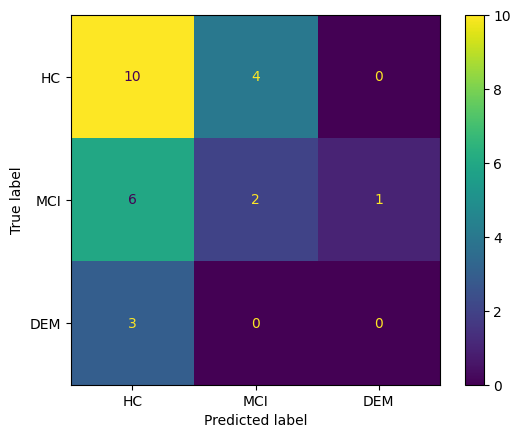

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.581
f1: 0.402
precision: 0.396
recall: 0.409


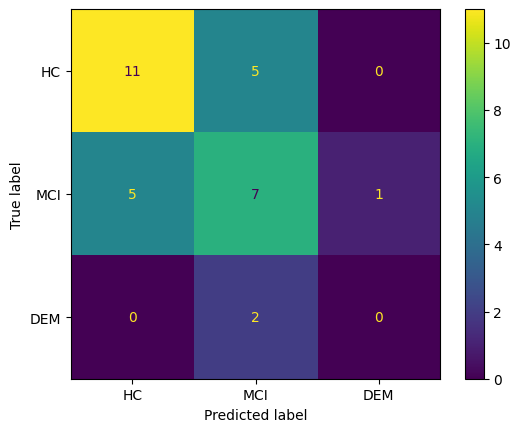

Training on base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 1.08675
Epoch 50, Loss: 0.01383
Epoch 100, Loss: 0.00072
Epoch 150, Loss: 0.00041
Epoch 200, Loss: 0.00027
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.484
f1: 0.337
precision: 0.352
recall: 0.332


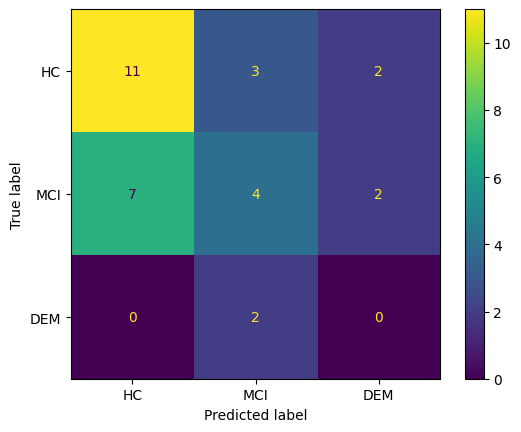

Fold 4:

    train set for base model: 100 samples; label count: Counter({0: 53, 1: 37, 2: 10}),
    train set for meta model: 26 samples; label count: Counter({0: 14, 1: 10, 2: 2}),
    dev set for meta model: 31 samples; label count: Counter({0: 15, 1: 12, 2: 4})
Class weights for base model:  tensor([0.6289, 0.9009, 3.3333])
Class weights for combined model:  tensor([0.6269, 0.8936, 3.5000])
----------- Task: CTD -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.11555
Epoch 50, Loss: 0.49528
Epoch 100, Loss: 0.06146
Epoch 150, Loss: 0.00405
Epoch 200, Loss: 0.00154
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.423
f1: 0.301
precision: 0.306
recall: 0.300


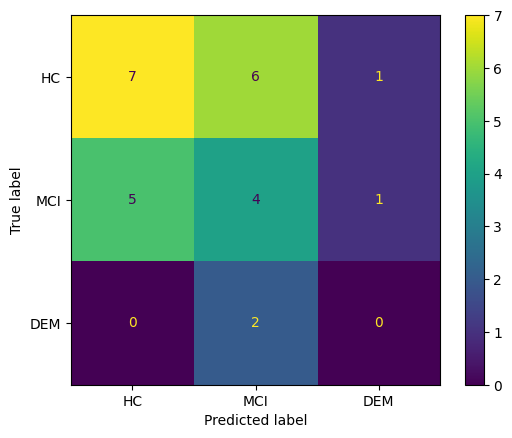

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.484
f1: 0.354
precision: 0.343
recall: 0.367


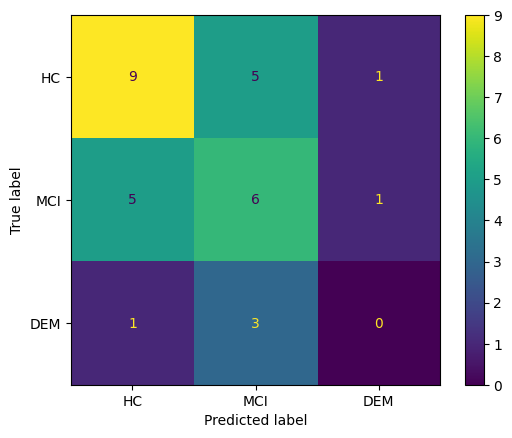

Training on base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 1.11510
Epoch 50, Loss: 0.54032
Epoch 100, Loss: 0.08700
Epoch 150, Loss: 0.00817
Epoch 200, Loss: 0.00299
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.452
f1: 0.326
precision: 0.315
recall: 0.339


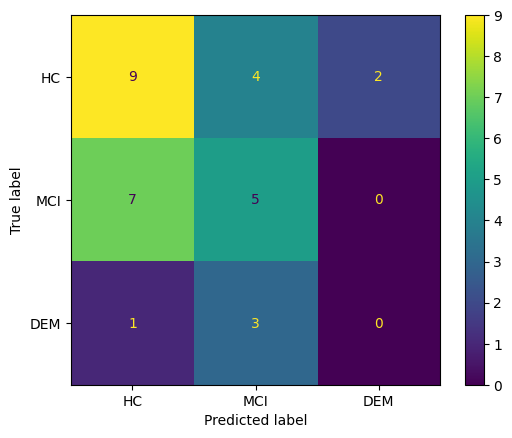

----------- Task: SFT -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.11629
Epoch 50, Loss: 0.22740
Epoch 100, Loss: 0.00254
Epoch 150, Loss: 0.00096
Epoch 200, Loss: 0.00059
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.538
f1: 0.395
precision: 0.423
recall: 0.371


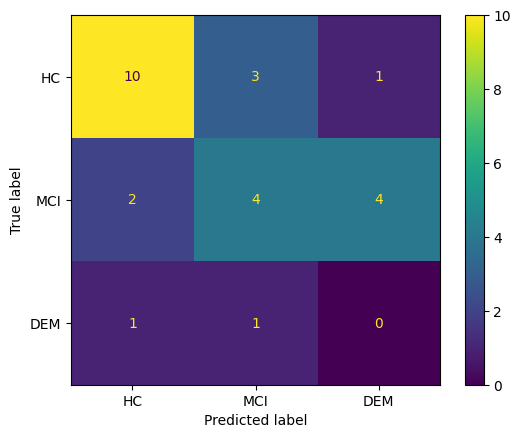

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.452
f1: 0.322
precision: 0.304
recall: 0.350


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


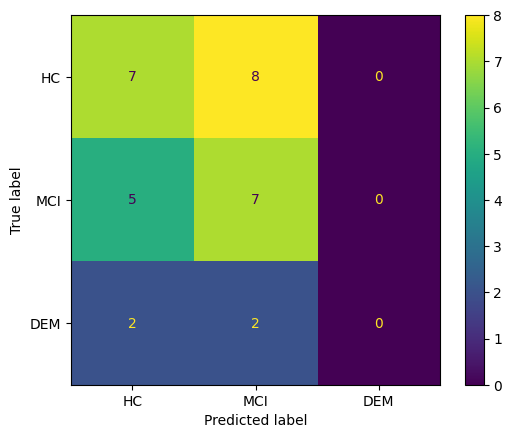

Training on base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 1.11199
Epoch 50, Loss: 0.30834
Epoch 100, Loss: 0.00598
Epoch 150, Loss: 0.00171
Epoch 200, Loss: 0.00094
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.484
f1: 0.335
precision: 0.318
recall: 0.361


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


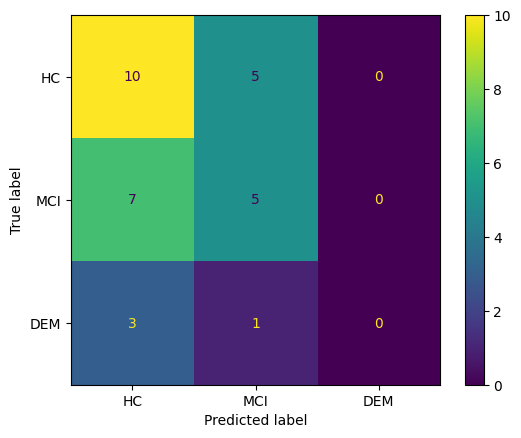

----------- Task: PFT -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.08122
Epoch 50, Loss: 0.00451
Epoch 100, Loss: 0.00026
Epoch 150, Loss: 0.00017
Epoch 200, Loss: 0.00013
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.462
f1: 0.414
precision: 0.400
recall: 0.457


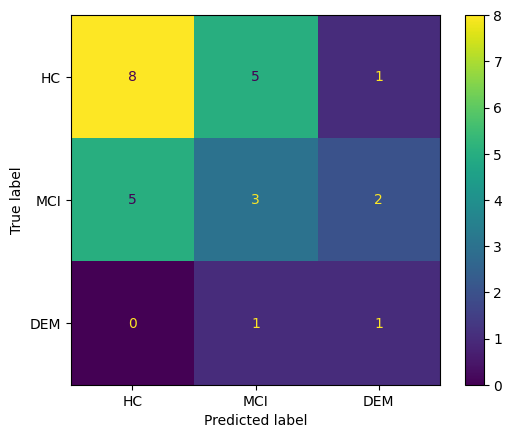

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.516
f1: 0.506
precision: 0.510
recall: 0.506


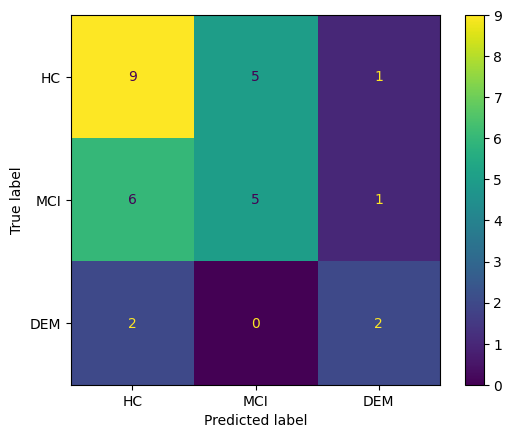

Training on base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 1.08506
Epoch 50, Loss: 0.01188
Epoch 100, Loss: 0.00055
Epoch 150, Loss: 0.00032
Epoch 200, Loss: 0.00022
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.387
f1: 0.340
precision: 0.343
recall: 0.344


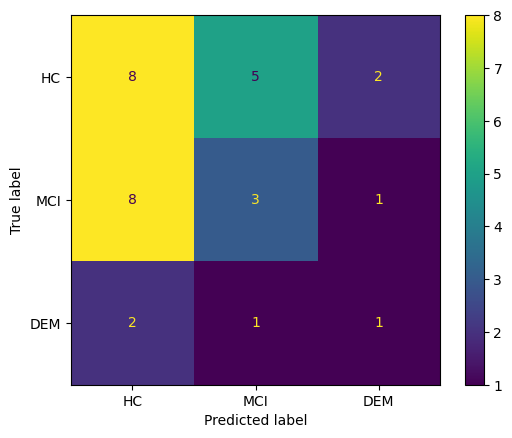


----------- Task: CTD -----------

              precision    recall  f1-score   support

           0     0.5618    0.6098    0.5848        82
           1     0.4483    0.4407    0.4444        59
           2     0.1000    0.0625    0.0769        16

    accuracy                         0.4904       157
   macro avg     0.3700    0.3710    0.3687       157
weighted avg     0.4721    0.4904    0.4803       157


----------- Task: SFT -----------

              precision    recall  f1-score   support

           0     0.6136    0.6585    0.6353        82
           1     0.4375    0.4746    0.4553        59
           2     0.2000    0.0625    0.0952        16

    accuracy                         0.5287       157
   macro avg     0.4170    0.3985    0.3953       157
weighted avg     0.5053    0.5287    0.5126       157


----------- Task: PFT -----------

              precision    recall  f1-score   support

           0     0.5824    0.6463    0.6127        82
           1     0.40

In [21]:
set_all_seeds(seed=42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

TASKS = ['CTD', 'SFT', 'PFT']
LABEL_MAPPING = {'HC': 0,
                 'MCI': 1,
                 'Dementia': 2}

metadata = pd.read_csv("PROCESS_METADATA_ALL.csv")
# shuffle df
metadata = metadata.sample(frac=1, random_state=42, ignore_index=False)
metadata['diagnosis_coded'] = metadata['diagnosis'].map(LABEL_MAPPING)

df_traindev = metadata[metadata['Tr/Tt/Dv'].isin(['train', 'dev'])]
id_traindev, label_traindev = df_traindev['anyon_IDs'], df_traindev['diagnosis_coded']
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf_dict = defaultdict(dict)

all_preds_across_folds = defaultdict(list)
all_trues_across_folds = defaultdict(list)

for fold_index, (train_index, dev_index) in enumerate(skf.split(id_traindev, label_traindev)):
    print(f"Fold {fold_index}:")
    base_train_id, ensemble_train_id, base_train_label, ensemble_train_label = train_test_split(id_traindev[train_index], label_traindev[train_index],
                                                    stratify=label_traindev[train_index],
                                                    test_size=0.2)
    print(f'''
    train set for base model: {len(base_train_label)} samples; label count: {Counter(base_train_label)},
    train set for meta model: {len(ensemble_train_label)} samples; label count: {Counter(ensemble_train_label)},
    dev set for meta model: {len(label_traindev[dev_index])} samples; label count: {Counter(label_traindev[dev_index])}''')

    class_weights_base = calculate_class_weights(base_train_label)
    combined_labels = np.concatenate([base_train_label, ensemble_train_label])
    class_weights_combined = calculate_class_weights(combined_labels)
    print('Class weights for base model: ', class_weights_base)
    print('Class weights for combined model: ', class_weights_combined)

    logits_for_ensemble_training = []
    pred_for_ensemble_training = []

    logits_for_ensemble_validation = []
    pred_for_ensemble_validation = []

    for task in TASKS:
        print(f'----------- Task: {task} -----------')
        transcript_folder = f"transcripts_outputFiles/{task}_outputFiles"
        base_train_datalist = get_datalist(base_train_id, base_train_label, transcript_folder)
        ensemble_train_datalist = get_datalist(ensemble_train_id, ensemble_train_label, transcript_folder)
        ensemble_dev_datalist = get_datalist(id_traindev[dev_index], label_traindev[dev_index], transcript_folder)
        # training gnn in order to get the logits
        print('Training base model...')
        trained_gnn = train_gnn(base_train_datalist)
        # get logits and pred for metamodel training
        print('Validating on meta model train set...')
        task_logits_ensemble_training, task_pred_ensemble_training, _, _ = eval_gnn(trained_gnn, ensemble_train_datalist, print_results=False)
        logits_for_ensemble_training.append(task_logits_ensemble_training)
        pred_for_ensemble_training.append(task_pred_ensemble_training)
        # get logits and pred for metamodel validation
        print('Validating on meta model dev set...')
        task_logits_ensemble_validation, task_pred_ensemble_validation, _, _ = eval_gnn(trained_gnn, ensemble_dev_datalist, print_results=False)
        logits_for_ensemble_validation.append(task_logits_ensemble_validation)
        pred_for_ensemble_validation.append(task_pred_ensemble_validation)

        # for comparison: gnn only, no metamodel
        print('Training on base model train set + meta model train set...')
        trained_gnn_individual_task = train_gnn(base_train_datalist + ensemble_train_datalist)
        print('Validating on meta model dev set...')
        _, all_preds, kf_dict[fold_index][f'{task}_gnn_results'], kf_dict[fold_index][f'{task}_gnn_cm_disp'] = eval_gnn(trained_gnn_individual_task, ensemble_dev_datalist)

        all_preds_across_folds[task].extend(all_preds.tolist())
        all_trues_across_folds[task].extend(label_traindev[dev_index].tolist())

    kf_dict[fold_index]['logits_for_ensemble_training'] = logits_for_ensemble_training
    kf_dict[fold_index]['logits_for_ensemble_validation'] = logits_for_ensemble_validation
    kf_dict[fold_index]['pred_for_ensemble_training'] = pred_for_ensemble_training
    kf_dict[fold_index]['pred_for_ensemble_validation'] = pred_for_ensemble_validation
    kf_dict[fold_index]['ensemble_train_label'] = ensemble_train_label
    kf_dict[fold_index]['ensemble_dev_label'] = label_traindev[dev_index]

for task in all_preds_across_folds.keys():
    print(f'\n----------- Task: {task} -----------\n')
    print(classification_report(all_trues_across_folds[task], all_preds_across_folds[task], digits=4))


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

set_all_seeds(seed=42)

# train and validate meta models
all_preds_meta_model = defaultdict(list)
all_trues_meta_model = defaultdict(list)


for fold in kf_dict.keys():
    print(f"Fold {fold}:")
    fold_dict = kf_dict[fold]
    logits_for_ensemble_training, ensemble_train_label, logits_for_ensemble_validation = fold_dict['logits_for_ensemble_training'], fold_dict['ensemble_train_label'], fold_dict['logits_for_ensemble_validation']
    ensemble_train_features = torch.cat(logits_for_ensemble_training, dim=1).detach()
    ensemble_train_labels = torch.tensor(ensemble_train_label.values, dtype=torch.int64).to(device)
    ensemble_validation_features = torch.cat(logits_for_ensemble_validation, dim=1).detach().to(device)

    class_weights_ensemble = calculate_class_weights(ensemble_train_label)
    class_weights_dict = {i: weight for i, weight in enumerate(class_weights_ensemble.tolist())}
    print(f'Class weights for fold {fold}: ', class_weights_dict)

    knn_model = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='minkowski')
    lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
    svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')
    rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

    # apply machine learning models as metamodel:
    for model_name, ensemble_model in {'lr': lr_model, 'svm': svm_model, 'rf': rf_model, 'knn': knn_model}.items():
        print(f'Training {model_name}...')
        ensemble_model.fit(ensemble_train_features, ensemble_train_labels)
        y_pred = ensemble_model.predict(ensemble_validation_features)
        ensemble_validation_labels = fold_dict['ensemble_dev_label'].to_numpy()
        all_preds_meta_model[model_name].extend(y_pred.tolist())
        all_trues_meta_model[model_name].extend(ensemble_validation_labels.tolist())

    # apply nn model as metamodel:
    nn_meta_model = train_nn_metamodel(features=ensemble_train_features, labels=ensemble_train_labels)
    nn_meta_model.eval()
    with torch.no_grad():
        ensemble_validation_labels = torch.tensor(fold_dict['ensemble_dev_label'].values, dtype=torch.int64).to(device)
        validation_pred = nn_meta_model(ensemble_validation_features).argmax(dim=1)
        all_preds_meta_model['nn'].extend(validation_pred.tolist())
        all_trues_meta_model['nn'].extend(ensemble_validation_labels.tolist())

for model_name in all_preds_meta_model.keys():
    print(f'\n----------- Model: {model_name} -----------\n')
    print(classification_report(all_trues_meta_model[model_name], all_preds_meta_model[model_name], digits=4))

Fold 0:
Class weights for fold 0:  {0: 0.6410256624221802, 1: 0.8333333134651184, 2: 4.166666507720947}
Training lr...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training svm...
Training rf...
Training knn...
Epoch 10, Loss: 0.5182
Epoch 20, Loss: 0.2468
Epoch 30, Loss: 0.0922
Epoch 40, Loss: 0.0330
Epoch 50, Loss: 0.0143
Fold 1:
Class weights for fold 1:  {0: 0.6410256624221802, 1: 0.8333333134651184, 2: 4.166666507720947}
Training lr...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training svm...
Training rf...
Training knn...
Epoch 10, Loss: 0.4848
Epoch 20, Loss: 0.1889
Epoch 30, Loss: 0.0708
Epoch 40, Loss: 0.0316
Epoch 50, Loss: 0.0170
Fold 2:
Class weights for fold 2:  {0: 0.6190476417541504, 1: 0.9629629850387573, 2: 2.8888888359069824}
Training lr...
Training svm...
Training rf...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training knn...
Epoch 10, Loss: 0.5273
Epoch 20, Loss: 0.2541
Epoch 30, Loss: 0.0891
Epoch 40, Loss: 0.0305
Epoch 50, Loss: 0.0136
Fold 3:
Class weights for fold 3:  {0: 0.6190476417541504, 1: 0.9629629850387573, 2: 2.8888888359069824}
Training lr...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training svm...
Training rf...
Training knn...
Epoch 10, Loss: 0.5540
Epoch 20, Loss: 0.3300
Epoch 30, Loss: 0.1587
Epoch 40, Loss: 0.0672
Epoch 50, Loss: 0.0286
Fold 4:
Class weights for fold 4:  {0: 0.6190476417541504, 1: 0.8666666746139526, 2: 4.333333492279053}
Training lr...
Training svm...
Training rf...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training knn...
Epoch 10, Loss: 0.3708
Epoch 20, Loss: 0.1936
Epoch 30, Loss: 0.0773
Epoch 40, Loss: 0.0362
Epoch 50, Loss: 0.0183

----------- Model: lr -----------

              precision    recall  f1-score   support

           0     0.5579    0.6463    0.5989        82
           1     0.4062    0.2203    0.2857        59
           2     0.1000    0.1875    0.1304        16

    accuracy                         0.4395       157
   macro avg     0.3547    0.3514    0.3383       157
weighted avg     0.4542    0.4395    0.4334       157


----------- Model: svm -----------

              precision    recall  f1-score   support

           0     0.5442    0.9756    0.6987        82
           1     0.4000    0.0678    0.1159        59
           2     0.0000    0.0000    0.0000        16

    accuracy                         0.5350       157
   macro avg     0.3147    0.3478    0.2715       157
weighted avg     0.4346    0.5350    0.4085       157


----------- Model: rf -----------

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m